In [1]:
import numpy as np
# import torch 
# !pip3 install lightgbm
# !pip3 install xgboost
# !pip3 install catboost
# !pip3 install tqdmt
# from sklearn.metrics import accuracy_score,precision_score,f1_score
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
import gc
import wandb
import time
from wandb.lightgbm import wandb_callback
from sklearn.metrics import roc_auc_score
from collections import defaultdict
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

In [2]:
config = {
    'dataset': 'A',  # for Dataset A or Dataset B
    'sample_size': 100000,
    'dst_offset': 0,
}

if config['dataset'] == 'A':
    config['dst_offset'] = 0
else:
    config['dst_offset'] = 791332

In [3]:
if config['dataset'] == 'A':
    edge_data = pd.read_csv(f'../train_csvs/edges_train_A.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'timestamp'])
else:
    edge_data = pd.read_csv(f'../train_csvs/edges_train_B.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'timestamp', 'edge_feat'])

edge_data['dst_id'] += config['dst_offset']
    
# 利用训练数据，构图，并整合每一个三元组对下的 timestamp 列表
graph_for_exist = dict()

for idx, i in enumerate(tqdm(edge_data.values)):
    src_id = i[0]
    dst_id = i[1]
    edge_type = i[2]
    timestamp = i[3]
    
    if src_id not in graph_for_exist.keys():
        graph_for_exist[src_id] = dict()
    if dst_id not in graph_for_exist.keys():
        graph_for_exist[dst_id] = dict()
    if edge_type not in graph_for_exist[src_id].keys():
        graph_for_exist[src_id][edge_type] = dict()
    if edge_type not in graph_for_exist[dst_id].keys():
        graph_for_exist[dst_id][edge_type] = dict()
    if src_id not in graph_for_exist[dst_id][edge_type].keys():
        graph_for_exist[dst_id][edge_type][src_id] = []
    if dst_id not in graph_for_exist[src_id][edge_type].keys():
        graph_for_exist[src_id][edge_type][dst_id] = []
    
    graph_for_exist[src_id][edge_type][dst_id].append(timestamp)
    graph_for_exist[dst_id][edge_type][src_id].append(timestamp)

print('timestamp state done!')

for key in graph_for_exist.keys():
    for k2 in graph_for_exist[key].keys():
        for k3, value in graph_for_exist[key][k2].items():
            graph_for_exist[key][k2][k3] = sorted(value)

print('done!')

100%|██████████| 27045268/27045268 [04:00<00:00, 112457.59it/s]


timestamp state done!
done!


In [4]:
# 方案三采样方法构造训练集
edge_csv = edge_data.sample(config['sample_size']).drop(columns=['timestamp', 'edge_feat'], errors='ignore')
edge_csv['start_time'] = edge_csv['end_time'] = 0
edge_csv['label'] = 1

# 方案三：根据原始边缘信息，重新采样，以下开始负样本采样
src_id_col = edge_csv['src_id'].values.copy()
dst_id_col = edge_csv['dst_id'].values.copy()
edge_type_col = edge_csv['edge_type'].values.copy()
np.random.shuffle(dst_id_col)  # dst id 与 edge type 列重新生成
np.random.shuffle(edge_type_col)
negative_edge_csv = pd.DataFrame(
    {'src_id': src_id_col,
     'dst_id': dst_id_col,
     'edge_type': edge_type_col,
     'start_time': 0,
     'end_time': 0,
     'label': 0})
train_a_data = pd.concat([edge_csv, negative_edge_csv]).reset_index(drop=True)
train_a_data['dst_id'] = train_a_data['dst_id']
train_a_data = pd.DataFrame(np.concatenate([train_a_data.values, train_a_data.values[:, [1, 0, 2, 3, 4, 5]], ]),
                            # 双向边
                            columns=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'])
train_a_data

,src_id,dst_id,edge_type,start_time,end_time,label
0,66355,5450,85,0,0,1
1,16660,34389,85,0,0,1
2,64560,45285,11,0,0,1
3,33634,23185,74,0,0,1
4,28905,13254,69,0,0,1
...,...,...,...,...,...,...
399995,34052,45285,69,0,0,0
399996,27718,55717,108,0,0,0
399997,28905,39771,74,0,0,0
399998,42063,3426,237,0,0,0


In [5]:
if config['dataset'] == 'A':
    # train_a_data = pd.read_csv('../train_csvs/new_train_A_100000.csv')
    train_a_node_features = pd.read_csv('../train_csvs/node_features.csv', header=None, names=['node_id', "feat_0", 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7'])
    train_a_edge_type_features = pd.read_csv('../train_csvs/edge_type_features.csv', header=None, names=['edge_type_id', "feat_0", 'feat_1', 'feat_2',])

dev_a_data = pd.read_csv(f'../test_csvs/input_{config["dataset"]}_initial.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'])
test_a_data = pd.read_csv(f'../test_csvs/input_{config["dataset"]}_final.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'])
test_a_data['label'] = -1

In [6]:
train_a_data['test_flag'] = 0
dev_a_data['test_flag'] = 1
test_a_data['test_flag'] = 3

tmp_test_data = pd.concat([dev_a_data, test_a_data])
tmp_test_data['dst_id'] += config['dst_offset']

all_data = pd.concat([train_a_data, tmp_test_data], ignore_index=True)

if config['dataset'] == 'A':
    all_data = all_data.merge(train_a_node_features, how='left', left_on='src_id', right_on='node_id')
    all_data.drop(columns=['node_id'], axis=0, inplace=True)
    all_data = all_data.merge(train_a_node_features, how='left', left_on='dst_id', right_on='node_id')
    all_data.drop(columns=['node_id'], axis=0, inplace=True)
    all_data = all_data.merge(train_a_edge_type_features, how='left', left_on='edge_type', right_on='edge_type_id')
    all_data.drop(columns=['edge_type_id'], axis=0, inplace=True)

all_data# .head(10)

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,feat_1_y,feat_2_y,feat_3_y,feat_4_y,feat_5_y,feat_6_y,feat_7_y,feat_0,feat_1,feat_2
0,66355,5450,85,0,0,1,0,31,-1,-1,...,-1,-1,-1,-1,221,-1,-1,53,1,61
1,16660,34389,85,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,83,-1,-1,53,1,61
2,64560,45285,11,0,0,1,0,3,-1,-1,...,-1,-1,-1,-1,155,-1,-1,74,6,72
3,33634,23185,74,0,0,1,0,25,-1,-1,...,-1,-1,-1,-1,56,-1,-1,201,9,71
4,28905,13254,69,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,177,-1,-1,30,6,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608192,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,-1,-1,-1,32,171,-1,-1,159,18,110
608193,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,-1,-1,-1,-1,155,-1,8,148,13,45
608194,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,-1,-1,-1,16,-1,-1,-1,209,9,0
608195,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,216,13,134


In [9]:
from collections import defaultdict

# 一元信息构造
node_adj_info = dict()

# 二元信息构造
two_node_adj_info = dict()

# 三元信息构造
si = edge_data['dst_id']
di = edge_data['src_id']

edge_data_tmp = edge_data.copy()
edge_data_tmp['src_id'] = si
edge_data_tmp['dst_id'] = di
edge_data_bi = pd.concat([edge_data, edge_data_tmp])
triple_node_adj_info = edge_data_bi.groupby(['src_id', 'dst_id', 'edge_type']).count().reset_index().rename(columns={'timestamp': 'sparse:group_val_(src_id,dst_id,edge_type)_count'})
del edge_data_tmp, edge_data_bi

for idx, (node_id, value) in enumerate(tqdm(graph_for_exist.items())):
    du = 0 # 节点的度，一共有多少条边
    unique_adj_node = set()
    nunique_adj_edge = len(value) # 节点一共邻接多少个不同边
    
    to_edge_dict = defaultdict(dict)  # key: dst_id, value: {edge_type: num, edge_type2: num2}
    
    for edge_type, adj_nodes in value.items():
        # print(edge_type, adj_nodes)
        for dst_id, tss in adj_nodes.items():
            unique_adj_node.add(dst_id)
            du += len(tss)
            
            to_edge_dict[dst_id][edge_type] = len(tss)
        
    node_adj_info[node_id] = {
        'sparse:group_val_(src_id)_count': du,
        'sparse:group_val_(src_id)_dst_id_nunique': len(unique_adj_node), # 节点一共邻接多少个不同点
        'sparse:group_val_(src_id)_edge_type_nunique': nunique_adj_edge,
    }
    for dst_id, info in to_edge_dict.items():
        two_node_adj_info[(node_id, dst_id)] = {
            'sparse:group_val_(src_id,dst_id)_count': sum(info.values()),
            'sparse:group_val_(src_id,dst_id)_edge_type_nunique': len(info),
        }

100%|██████████| 19442/19442 [00:23<00:00, 832.45it/s] 


In [10]:
node_adj_info_pd = pd.DataFrame.from_dict(node_adj_info, orient='index').reset_index()
two_node_adj_info_pd = pd.DataFrame.from_dict(two_node_adj_info, orient='index').reset_index()

two_node_adj_info_pd

,level_0,level_1,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique"
0,106,28905,91306,188
1,106,39520,6671,121
2,106,45915,6505,129
3,106,61213,3013,109
4,106,27194,186,37
...,...,...,...,...
2925753,20584,50050,4,3
2925754,20584,64560,2,2
2925755,20584,45915,1,1
2925756,20584,28905,1,1


In [11]:
from scipy import sparse

row = []
col = []
data = []

for (src_id, dst_id), value in two_node_adj_info.items():
    row.append(src_id)
    col.append(dst_id)
    data.append(value['sparse:group_val_(src_id,dst_id)_count'])
one_hop_count_matrix = sparse.csr_matrix((data, (row, col)))
one_hop_count_matrix

<69984x69984 sparse matrix of type '<class 'numpy.int64'>'
	with 2925758 stored elements in Compressed Sparse Row format>

In [12]:
two_hop_count_matrix = one_hop_count_matrix * one_hop_count_matrix
two_hop_count_matrix

<69984x69984 sparse matrix of type '<class 'numpy.int64'>'
	with 374466676 stored elements in Compressed Sparse Row format>

In [13]:
two_hop_count_list = []

for i in tqdm(two_node_adj_info_pd.values):
    src_id = i[0]
    dst_id = i[1]
    two_hop_count_list.append(two_hop_count_matrix[src_id, dst_id])
    
two_node_adj_info_pd['two_hop_count_list'] = two_hop_count_list
two_node_adj_info_pd

100%|██████████| 2925758/2925758 [03:54<00:00, 12484.36it/s]


,level_0,level_1,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique",two_hop_count_list
0,106,28905,91306,188,30637224999
1,106,39520,6671,121,15381684086
2,106,45915,6505,129,16506712019
3,106,61213,3013,109,4293185422
4,106,27194,186,37,517666723
...,...,...,...,...,...
2925753,20584,50050,4,3,1815
2925754,20584,64560,2,2,213462
2925755,20584,45915,1,1,177922
2925756,20584,28905,1,1,597560


In [14]:
# 拼接一元信息
all_data = all_data.merge(node_adj_info_pd, how='left', left_on='src_id', right_on='index').drop(columns=['index'], axis=0)
# 拼接二元信息
all_data = all_data.merge(node_adj_info_pd, how='left', left_on='dst_id', right_on='index').drop(columns=['index'], axis=0)
# 拼接三元信息
all_data = all_data.merge(two_node_adj_info_pd, how='left', left_on=['src_id', 'dst_id'], right_on=['level_0', 'level_1']).fillna(0).drop(columns=['level_0', 'level_1'], axis=0)
all_data = all_data.merge(triple_node_adj_info, how='left', left_on=['src_id', 'dst_id', 'edge_type'], right_on=['src_id', 'dst_id', 'edge_type']).fillna(0)

In [15]:
all_data

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,sparse:group_val_(src_id)_count_x,sparse:group_val_(src_id)_dst_id_nunique_x,sparse:group_val_(src_id)_edge_type_nunique_x,sparse:group_val_(src_id)_count_y,sparse:group_val_(src_id)_dst_id_nunique_y,sparse:group_val_(src_id)_edge_type_nunique_y,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique",two_hop_count_list,"sparse:group_val_(src_id,dst_id,edge_type)_count"
0,66355,5450,85,0,0,1,0,31,-1,-1,...,12065,1082,149,37556,1664,191,33.0,8.0,1.062373e+07,1.0
1,16660,34389,85,0,0,1,0,-1,-1,-1,...,108373,4148,216,62314,2766,196,310.0,52.0,2.225039e+08,1.0
2,64560,45285,11,0,0,1,0,3,-1,-1,...,778005,9175,221,3295131,11958,245,77368.0,181.0,1.485649e+11,6975.0
3,33634,23185,74,0,0,1,0,25,-1,-1,...,125783,4355,206,410287,5512,228,763.0,77.0,2.085524e+09,63.0
4,28905,13254,69,0,0,1,0,-1,-1,-1,...,9675998,19179,246,63419,2915,197,12906.0,166.0,3.077859e+09,429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608192,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,3746,607,148,44551,1569,189,30.0,15.0,3.652753e+06,0.0
608193,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,3746,607,148,4372,491,130,0.0,0.0,0.000000e+00,0.0
608194,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,3746,607,148,777,183,78,0.0,0.0,0.000000e+00,0.0
608195,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,3746,607,148,728553,10035,234,93.0,24.0,5.185534e+07,10.0


## 拼接外部 node embedding

In [16]:
def read_emb_data(filepath):
    if not os.path.exists(filepath):
        return dict()
    f = open(filepath, 'r')
    num_count, num_dim = map(int, f.readline().split())

    node_id_emb = dict()
    for data in f.readlines():
        data = data.strip().split(' ')

        node_id = int(data[0])
        embed = np.array(data[1:], dtype=float)
        node_id_emb[node_id] = embed
    return node_id_emb

# 使用 LINE 生成的 embedding
if config['dataset'] == 'A':
    emb_path = '../train_csvs/graph_src_dst_id/graph_src_dst_id_by_all_edge_type_200_neg1-1_judge0.875.emb'
else:
    emb_path = '../train_csvs/graph_src_dst_id_b/dataset_b_graph_src_dst_id_by_all_edge_type2.emb'
all_node_emb = read_emb_data(emb_path)
all_node_emb_pd = pd.DataFrame.from_dict(all_node_emb, orient='index')

In [17]:
all_data = all_data.merge(all_node_emb_pd, how='left', left_on='src_id', right_index=True)
all_data = all_data.merge(all_node_emb_pd, how='left', left_on='dst_id', right_index=True)
all_data

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,66355,5450,85,0,0,1,0,31,-1,-1,...,0.241055,-0.246519,0.066187,0.036562,-0.044310,0.017722,-0.037613,0.298281,-0.129905,-0.223183
1,16660,34389,85,0,0,1,0,-1,-1,-1,...,0.006220,0.212180,-0.021973,-0.027233,0.368144,0.009775,0.049608,0.190529,0.000508,0.178851
2,64560,45285,11,0,0,1,0,3,-1,-1,...,-0.013199,0.136821,-0.166146,0.036896,0.248007,-0.478729,0.028857,-0.149690,0.116603,0.181092
3,33634,23185,74,0,0,1,0,25,-1,-1,...,-0.065490,-0.206730,0.258178,0.000431,0.371386,0.009454,0.205325,-0.204010,0.127957,-0.000864
4,28905,13254,69,0,0,1,0,-1,-1,-1,...,-0.048768,-0.096864,-0.022482,0.133885,0.138584,0.113427,-0.133563,0.218645,-0.156454,0.109257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608192,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,0.139255,-0.229574,-0.071373,0.127565,0.642420,0.253823,0.428848,0.323048,0.101695,0.084716
608193,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,0.025879,-0.022462,0.301820,0.019580,0.288837,0.143800,0.275378,-0.142744,-0.162683,0.075854
608194,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,-0.321030,0.068310,0.256207,0.100260,-0.183363,0.213994,-0.190439,0.019576,0.128220,-0.438405
608195,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,-0.035734,-0.082499,-0.054318,0.119458,0.136925,0.177073,-0.013822,0.130459,0.081751,0.164094


In [18]:
# 将 src_id, dst_id 两个节点 embedding 的点积以及余弦相似度加入特征中
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

dot_product_list = []
cos_sim_list = []

for i in tqdm(all_data.values):
    src_id = i[0]
    dst_id = i[1]
    src_emb = all_node_emb[src_id]
    dst_emb = all_node_emb[dst_id]
    
    dot_product_list.append(sum(src_emb * dst_emb))
    cos_sim_list.append(cos_sim(src_emb, dst_emb))
    
all_data['dot_product'] = dot_product_list
all_data['cos_sim'] = cos_sim_list
all_data

100%|██████████| 608197/608197 [01:09<00:00, 8738.71it/s] 


,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y,dot_product,cos_sim
0,66355,5450,85,0,0,1,0,31,-1,-1,...,0.066187,0.036562,-0.044310,0.017722,-0.037613,0.298281,-0.129905,-0.223183,1.610020,0.605973
1,16660,34389,85,0,0,1,0,-1,-1,-1,...,-0.021973,-0.027233,0.368144,0.009775,0.049608,0.190529,0.000508,0.178851,1.158197,0.578190
2,64560,45285,11,0,0,1,0,3,-1,-1,...,-0.166146,0.036896,0.248007,-0.478729,0.028857,-0.149690,0.116603,0.181092,0.986517,0.668790
3,33634,23185,74,0,0,1,0,25,-1,-1,...,0.258178,0.000431,0.371386,0.009454,0.205325,-0.204010,0.127957,-0.000864,0.387319,0.535591
4,28905,13254,69,0,0,1,0,-1,-1,-1,...,-0.022482,0.133885,0.138584,0.113427,-0.133563,0.218645,-0.156454,0.109257,0.631400,0.583416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608192,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,-0.071373,0.127565,0.642420,0.253823,0.428848,0.323048,0.101695,0.084716,2.792486,0.668590
608193,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,0.301820,0.019580,0.288837,0.143800,0.275378,-0.142744,-0.162683,0.075854,0.343162,0.522803
608194,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,0.256207,0.100260,-0.183363,0.213994,-0.190439,0.019576,0.128220,-0.438405,0.332295,0.517548
608195,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,-0.054318,0.119458,0.136925,0.177073,-0.013822,0.130459,0.081751,0.164094,0.259429,0.523477


In [19]:
# 将离散列转化为 object 类型
global_sparse_columns = ['src_id',
                         'dst_id',
                         'edge_type',
                        ]# + [i for i in all_data.columns if i.startswith('feat_')]
all_data[global_sparse_columns] = all_data[global_sparse_columns].astype('str')
        
# 将连续列转化为 float 类型
global_dense_columns = [
    # 'exist_triple_count',
    # 'exist_tuple_count',
]
all_data[global_dense_columns] = all_data[global_dense_columns].astype('float')

# 打印所有的列名，及其类型
# for i, col in enumerate(all_data):
#     print(col, ' --> ', all_data[col].dtype)

In [20]:
all_features = all_data.copy()
print('all_features: ', all_features.shape)

all_features:  (608197, 438)


In [21]:
# 为 float 列中的 NAN 填充该列均值
na_count_sum = 0
for i in all_features.columns:
    na_count = sum(all_features[i].isna())
    if na_count:
        na_count_sum += 1
#         print(i, na_count)
#         print(all_features[i][~all_features[i].isna()].mean())
        all_features[i] = all_features[i].fillna(all_features[i][~all_features[i].isna()].mean())
print(na_count_sum)

0


In [23]:
# 测试了一下，只有 merge 的时候导致的 na，因此填充 -1
all_features = all_features.fillna(-1)

if config['dataset'] == 'A':
    del_columns = [# 'src_id', 'dst_id', 'edge_type', 
                           'start_time',
                           'end_time',
       # 'sparse:group_val_(src_id)_count_x',
       # 'sparse:group_val_(src_id)_dst_id_nunique_x',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_x',
       # 'sparse:group_val_(src_id)_count_y',
       # 'sparse:group_val_(src_id)_dst_id_nunique_y',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_y',
       # 'sparse:group_val_(src_id,dst_id)_count',       # Dataset B  不注释
       # 'sparse:group_val_(src_id,dst_id)_edge_type_nunique',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id,edge_type)_count',  # 对 Dataset A 会影响效果，Dataset B  不注释
       # 'two_hop_count_list',
        # 'edge_feat',
        # 'exist_triple_count',
        # 'exist_tuple_count',
                            # 'timestamp',
                          ]
else:
    del_columns = [# 'src_id', 'dst_id', 'edge_type', 
                           'start_time',
                           'end_time',
       # 'sparse:group_val_(src_id)_count_x',
       'sparse:group_val_(src_id)_dst_id_nunique_x',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_x',
       # 'sparse:group_val_(src_id)_count_y',
       'sparse:group_val_(src_id)_dst_id_nunique_y',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_y',
       'sparse:group_val_(src_id,dst_id)_count',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id)_edge_type_nunique',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id,edge_type)_count',  # 对 Dataset A 会影响效果，Dataset B  不注释
       # 'two_hop_count_list',
        # 'edge_feat',
        # 'exist_triple_count',
        # 'exist_tuple_count',
                            # 'timestamp',
                          ]

all_features.drop(columns=del_columns, inplace=True, errors='ignore')

# for column_name in all_features.columns:
#     if column_name.startswith('feat_'):
#         all_features[column_name] = all_features[column_name].astype(str)

all_features

,src_id,dst_id,edge_type,label,test_flag,feat_0_x,feat_1_x,feat_2_x,feat_3_x,feat_4_x,...,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y,dot_product,cos_sim
0,66355,5450,85,1,0,31,-1,-1,-1,-1,...,0.066187,0.036562,-0.044310,0.017722,-0.037613,0.298281,-0.129905,-0.223183,1.610020,0.605973
1,16660,34389,85,1,0,-1,-1,-1,-1,-1,...,-0.021973,-0.027233,0.368144,0.009775,0.049608,0.190529,0.000508,0.178851,1.158197,0.578190
2,64560,45285,11,1,0,3,-1,-1,-1,-1,...,-0.166146,0.036896,0.248007,-0.478729,0.028857,-0.149690,0.116603,0.181092,0.986517,0.668790
3,33634,23185,74,1,0,25,-1,-1,-1,-1,...,0.258178,0.000431,0.371386,0.009454,0.205325,-0.204010,0.127957,-0.000864,0.387319,0.535591
4,28905,13254,69,1,0,-1,-1,-1,-1,-1,...,-0.022482,0.133885,0.138584,0.113427,-0.133563,0.218645,-0.156454,0.109257,0.631400,0.583416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608192,69980,49214,176,-1,3,29,-1,-1,-1,-1,...,-0.071373,0.127565,0.642420,0.253823,0.428848,0.323048,0.101695,0.084716,2.792486,0.668590
608193,69980,52874,33,-1,3,29,-1,-1,-1,-1,...,0.301820,0.019580,0.288837,0.143800,0.275378,-0.142744,-0.162683,0.075854,0.343162,0.522803
608194,69980,55746,209,-1,3,29,-1,-1,-1,-1,...,0.256207,0.100260,-0.183363,0.213994,-0.190439,0.019576,0.128220,-0.438405,0.332295,0.517548
608195,69980,60642,71,-1,3,29,-1,-1,-1,-1,...,-0.054318,0.119458,0.136925,0.177073,-0.013822,0.130459,0.081751,0.164094,0.259429,0.523477


In [24]:
def category_idization(features, encoding='le'):
    # 类别 id 化
    
    cat_indices = None
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # print('transform object -> int id, ', col)
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                cat_indices.append(col)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Data Shape: ', features.shape)
    print('sparse column: ', cat_indices)
    print('sparse column idx: ', [features.columns.get_loc(key) for key in cat_indices])
    
    return features, cat_indices

In [25]:
all_features, cat_indices = category_idization(features=all_features.copy(), encoding='le')


Data Shape:  (608197, 435)
sparse column:  ['src_id', 'dst_id', 'edge_type']
sparse column idx:  [0, 1, 2]


In [29]:
model = None
best_iteration = None
train_features = None
valid_features = None

def get_model(args):
    if args['model_name'] == 'cbt':
        model = cbt.CatBoostClassifier(
                            n_estimators = args['n_estimators'],
                            num_leaves=args['num_leaves'],
                            depth=args['max_depth'],
                            objective=None,
                            # boosting_type = args['boosting_type'],
                            # class_weights = args['class_weight'],
                            learning_rate = args['learning_rate'],
                            # reg_alpha = args['reg_alpha'],
                            reg_lambda = args['reg_lambda'],
                            subsample = args['subsample'],
                            # subsample_for_bin=args['subsample_for_bin'],
                            colsample_bylevel=args['colsample_bytree'],
                            # n_jobs = -1,
                            random_state = args['random_seed'],
                            eval_metric="AUC",
                            # task_type="GPU",
                            od_type="Iter",
                            border_count=64,
                        )
    elif args['model_name'] == 'lgb':
        model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
                           num_leaves=args['num_leaves'],
                           max_depth=args['max_depth'],
                           objective = 'binary',
                           boosting_type = args['boosting_type'],
                           class_weight = args['class_weight'],
                           learning_rate = args['learning_rate'], 
                           reg_alpha = args['reg_alpha'],
                           reg_lambda = args['reg_lambda'], 
                           subsample = args['subsample'],
                           subsample_for_bin=args['subsample_for_bin'],
                           colsample_bytree=args['colsample_bytree'],
                           n_jobs = -1,
                           random_state = args['random_seed'],
                           importance_type='gain')
    return model


def model_fit(model, train_features, train_labels, valid_features, valid_labels, test_features, test_labels, cat_indices, args):
    if args['model_name'] == 'cbt':
        model.fit(train_features,
                  train_labels,
        #           eval_metric = [
        #                 lgb_fbeta_0_3,
        #                 'auc',
        #           ],
                  eval_set = [
                      # (valid_features, valid_labels),
                      (test_features, test_labels),
                      # (train_features, train_labels)
                  ],
        #           eval_names = [
        #               'valid',
        #               'train'
        #           ],
                  cat_features = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  # plot=True,
                 )
        if args['use_wandb']:
            for iter in range(len(model.evals_result_['learn']['Logloss'])):
                # 将结果 log 进 wandb
                wandb.log(
                    {'train_binary_logloss': model.evals_result_['learn']['Logloss'][iter],
                     'dev_binary_logloss': model.evals_result_['validation']['Logloss'][iter],
                     'dev_auc': model.evals_result_['validation']['AUC'][iter],
                    }
                )
        return {
                    'train': model.evals_result_['learn'],
                    'valid': model.evals_result_['validation'],
               }, model.best_iteration_, {
                    'train': {'binary_logloss': model.best_score_['learn']['Logloss']},
                    'valid': {'binary_logloss': model.best_score_['validation']['Logloss']},
                }
    
    elif args['model_name'] == 'lgb':
        train_features = np.array(train_features)
        valid_features = np.array(valid_features)
        test_features = np.array(test_features)
        
        model.fit(train_features,
                  train_labels,
                  eval_metric = [
                        # lgb_fbeta_0_3,
                        'auc',
                  ],
                  eval_set = [
                      (valid_features, valid_labels),
                      (test_features, test_labels),
                      (train_features, train_labels)
                  ],
                  eval_names = [
                      'valid',
                      'dev',
                      'train',
                  ],
                  categorical_feature = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
                 )
        best_iteration = model.best_iteration_  # 模型默认 best iteration
        best_iteration_with_logloss = np.argmin(model.evals_result_['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
        best_iteration_with_auc = np.argmax(model.evals_result_['valid']['auc']) # 最好的 auc 的 iter
        # best_iteration_with_fscore = np.argmax(model.evals_result_['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        
        # 经过测试，选 fbeta-0.3 最高的优于 auc、优于 logloss
        print('--> best_iteration (default): ', best_iteration)
        print('--> best_iteration (binary_logloss): ', best_iteration_with_logloss)
        print('--> best_iteration (auc): ', best_iteration_with_auc)
        # print('--> best_iteration (fbeta-0.3): ', best_iteration_with_fscore)
        
        return model.evals_result_, best_iteration_with_auc, model.best_score_

    
def model_predict_proba(model, features, best_iteration, args):
    res = None
    if args['model_name'] == 'cbt':
        res = model.predict_proba(features)
    elif args['model_name'] == 'lgb':
        features = np.array(features)
        res = model.predict_proba(features, num_iteration = best_iteration)
    return res


def sigle_model(features, dev_features, test_features, args, n_folds = 5):
    global model, best_iteration, train_features, valid_features
    model = None
    
    #提取ID
    # train_ids = features['id']
    dev_ids = dev_features.index
    test_ids = test_features.index
    
    # 提取训练集的结果
    labels = features['label']
    dev_labels = dev_features['label']
    # 移除ID和target,date
    # train_date_name = [i for i in features.columns if "date" in i]
    
    del_name = ['label', 'test_flag']
#     del_name = ['label', 'request_id'] # 后面的 cat index 编号可能出问题
    features = features.drop(columns = del_name)
    dev_features = dev_features.drop(columns = del_name)
    test_features = test_features.drop(columns = del_name)

    new_cat_indices = [features.columns.get_loc(key) for key in cat_indices]  # 类别列 idx 根据列名称获取

    print('del_columns_name: ', del_name)
    print('new_cat_indices: ', new_cat_indices)
    print('all_features (in model): ', features.iloc[:, new_cat_indices])
    # return
    
    # print(features.columns)
    # print(test_features.columns)

    feature_names = list(features.columns)
    print(feature_names)
    
#     print(features.iloc[:, new_cat_indices])
#     return
    
    # features = np.array(features)
    # test_features = np.array(test_features)

    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = args['random_seed'])
    
    feature_importance_values = np.zeros(len(feature_names))
    
    dev_predictions = np.zeros(dev_features.shape[0])
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = {}
    train_scores = {}
    valid_fbeta = []
    all_model = []
    
    group_name = '{}'.format(wandb.util.generate_id())
    
    for fold_idx, (train_indices, valid_indices) in enumerate(k_fold.split(features)):
        if config['use_wandb']:
            # 配置 wandb
            wandb.init(project=f'wsdm2022tgp_tree_solution_{config["dataset"]}',
                       entity='graphml',
                       config=args,
                       group=group_name,
                       job_type='fold-{}'.format(fold_idx))
        
        train_features, train_labels = features.loc[train_indices], labels[train_indices]
        valid_features, valid_labels = features.loc[valid_indices], labels[valid_indices]
        
        #建模
        model = get_model(args)
#         model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
#                                    num_leaves=args['num_leaves'],
#                                    max_depth=args['max_depth'],
#                                    objective = 'binary',
#                                    boosting_type = args['boosting_type'],
#                                    class_weight = args['class_weight'],
#                                    learning_rate = args['learning_rate'], 
#                                    reg_alpha = args['reg_alpha'],
#                                    reg_lambda = args['reg_lambda'], 
#                                    subsample = args['subsample'],
#                                    subsample_for_bin=args['subsample_for_bin'],
#                                    colsample_bytree=args['colsample_bytree'],
#                                    n_jobs = -1,
#                                    random_state = args['random_seed'],
#                                    importance_type='gain')
        
        # 训练模型
#         print('训练特征维度：', train_features.shape)
#         print(train_features[:, new_cat_indices])
        evals_result_, best_iteration, best_score_ = model_fit(model, train_features, train_labels, valid_features, valid_labels, dev_features, dev_labels, new_cat_indices, args)
#         model.fit(train_features,
#                   train_labels,
#                   eval_metric = [
#                         lgb_fbeta_0_3,
#                         'auc',
#                   ],
#                   eval_set = [
#                       (valid_features, valid_labels),
#                       (train_features, train_labels)
#                   ],
#                   eval_names = [
#                       'valid',
#                       'train'
#                   ],
#                   categorical_feature = new_cat_indices,
#                   early_stopping_rounds = 3000,
#                   verbose = args['verbose'],
#                   callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
#                  )
        
#         best_iteration = model.best_iteration_  # 模型默认 best iteration
#         best_iteration_with_logloss = np.argmin(evals_results['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
#         best_iteration_with_auc = np.argmax(evals_results['valid']['auc']) # 最好的 auc 的 iter
#         best_iteration_with_fscore = np.argmax(evals_results['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        all_model.append(model)
        
        # 特征重要性
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # 做预测
        proba_iteration = best_iteration
        print('--> use iteration [{}] for proba'.format(proba_iteration))
        dev_predictions += model_predict_proba(model, dev_features, proba_iteration, args)[:, 1] / k_fold.n_splits
        test_predictions += model_predict_proba(model, test_features, proba_iteration, args)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model_predict_proba(model, valid_features, proba_iteration, args)[:, 1]
        

        print('--> valid label = 1 占比：', sum(out_of_fold[valid_indices] >= 0.5) / len(out_of_fold[valid_indices]))
        
        # print(model.best_score_)
#         valid_score = model.best_score_['valid']['auc']
#         train_score = model.best_score_['train']['auc']
#         fbeta = lgb_fbeta(valid_labels, out_of_fold[valid_indices], beta=0.3)

        for score_name in best_score_['train'].keys():
            if score_name in valid_scores:
                train_scores[score_name].append(best_score_['train'][score_name])
                valid_scores[score_name].append(best_score_['valid'][score_name])
            else:
                train_scores[score_name] = [best_score_['train'][score_name]]
                valid_scores[score_name] = [best_score_['valid'][score_name]]
        
       # valid_fbeta.append(fbeta)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
        if config['use_wandb']:
            # 配置 wandb end
            #wandb.log(metrics[['train_auc', 'valid_auc', 'valid-fbeta']].iloc[-1].to_dict())
            wandb.finish()
            pass
        
    submission = pd.DataFrame({'test_ids': test_ids, 'test_label': test_predictions})
    dev_submission = pd.DataFrame({'dev_ids': dev_ids, 'dev_label': dev_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    

    if 'auc' in valid_scores:
        valid_auc = roc_auc_score(labels, out_of_fold)
        valid_scores['auc'].append(valid_auc)
        train_scores['auc'].append(np.mean(train_scores['auc']))
    if 'fbeta-0.3' in valid_scores:
        valid_fbeta = lgb_fbeta(labels, out_of_fold, beta=0.3)
        valid_scores['fbeta-0.3'].append(valid_fbeta)
        train_scores['fbeta-0.3'].append(np.mean(train_scores['fbeta-0.3']))
    if 'binary_logloss' in train_scores:
        train_scores['binary_logloss'].append(np.mean(train_scores['binary_logloss']))
        valid_scores['binary_logloss'].append(np.mean(valid_scores['binary_logloss']))

    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    print('dev auc: ', roc_auc_score(dev_labels, dev_predictions))
    
    #print(train_scores)
    #print(valid_scores)
    #print(fold_names)
    
    metrics = pd.DataFrame({'fold': fold_names,
                            # **train_scores,
                            **valid_scores,
                           }) 
    
    return dev_submission, submission, feature_importances, metrics, all_model, out_of_fold

In [30]:
sweep_config = {
  # "name" : "my-sweep",
  'metric': {'name': 'valid_fbeta-0.3', 'goal': 'maximize'},
  "method" : "bayes",
  "parameters" : {
    "colsample_bytree": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
    "learning_rate" :{
        "distribution": "uniform",
        "min": 0.005,
        "max": 0.2
    },
    "num_leaves": {
        "distribution": "int_uniform",
        "min": 8,
        "max": 64
    },
    "random_seed": {
        "distribution": "int_uniform",
        "min": 0,
        "max": 2048
    },
    "reg_alpha": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "reg_lambda": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "subsample": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
  }
}

In [31]:
config = {
    **config,
    'random_seed': 42, # 42, 50
    'num_leaves': 31,
    'max_depth': 6,  # -1, 6
    'subsample_for_bin': 200000,
    'colsample_bytree': 0.9,
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,  # 50
    'subsample': 1.0,
    'model_name': 'cbt',  # lgb, cbt, xgb
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    'n_folds': 5,
    
    'verbose': 50, # 每隔多少步输出
    'exec_time': time.strftime("%Y.%m.%d-%H.%M.%S", time.localtime()),
    
    'use_wandb': False,
    'run_sweeps': False,
}

# config.update({
#     # sweep 调参的结果
#     'colsample_bytree': 0.5441,
#     'learning_rate': 0.09151,
#     'num_leaves': 63,
#     'random_seed': 751,
#     'reg_alpha': 0.155,
#     'reg_lambda': 0.1032,
#     'subsample': 0.8299,
# })

# 构建训练集与测试集
all_features = all_features.reset_index(drop=True)
train_features = all_features[all_features['test_flag'] == 0]
dev_features = all_features[all_features['test_flag'] == 1]
test_features = all_features[all_features['test_flag'] == 3]

if config['run_sweeps']:
    # 执行超参调优
    config['use_wandb'] = False
    sweep_id = wandb.sweep(sweep_config,
                           entity='imqxms',
                           project='AntGraph')
    def sweep_train():
        with wandb.init() as run:
            config.update(wandb.config)
            
            submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, test_features, args=config, n_folds = config['n_folds'])
            print('Baseline metrics')
            print(metrics)
            
            # 平均每一折中每个 step 的效果
            res_dict = dict()
            for i in range(config['n_folds']):
                for key in all_model[i].evals_result_['valid'].keys():
                    if 'valid_{}'.format(key) not in res_dict:
                        res_dict['valid_{}'.format(key)] = 0.0
                    res_dict['valid_{}'.format(key)] += np.array(all_model[i].evals_result_['valid'][key]) * 1.0 / config['n_folds']
            
            # 将平均后的效果 log 进 wandb
            for i in range(len(res_dict['valid_binary_logloss'])):
                wandb.log({key:res_dict[key][i] for key in res_dict.keys()})
            
            if sweep_config['metric']['goal'] == 'maximize':
                # 找出最佳效果的 step，并将该 step 的结果 log 在 wandb 中（为了 sweep 调参）
                best_idx = res_dict[sweep_config['metric']['name']].argmax()
            else:
                best_idx = res_dict[sweep_config['metric']['name']].argmin()
            wandb.log({i: res_dict[i][best_idx] for i in res_dict.keys()})  # 将最佳效果 log 一下
                                
    wandb.agent(sweep_id, function=sweep_train, count=30)
else:
    dev_submission, submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, dev_features, test_features, args=config, n_folds = config['n_folds'])
    print('Baseline metrics')
    print(metrics)

del_columns_name:  ['label', 'test_flag']
new_cat_indices:  [0, 1, 2]
all_features (in model):          src_id  dst_id  edge_type
0         9563    7312        212
1         1091    4016        212
2         9269    5785         12
3         4002    2132        201
4         3175     523        195
...        ...     ...        ...
399995    4064    5785        195
399996    2965    7507         10
399997    3175    4868        201
399998    5454    3981        140
399999    3175    3152        191

[400000 rows x 3 columns]
['src_id', 'dst_id', 'edge_type', 'feat_0_x', 'feat_1_x', 'feat_2_x', 'feat_3_x', 'feat_4_x', 'feat_5_x', 'feat_6_x', 'feat_7_x', 'feat_0_y', 'feat_1_y', 'feat_2_y', 'feat_3_y', 'feat_4_y', 'feat_5_y', 'feat_6_y', 'feat_7_y', 'feat_0', 'feat_1', 'feat_2', 'sparse:group_val_(src_id)_count_x', 'sparse:group_val_(src_id)_dst_id_nunique_x', 'sparse:group_val_(src_id)_edge_type_nunique_x', 'sparse:group_val_(src_id)_count_y', 'sparse:group_val_(src_id)_dst_id_nunique_y'

In [28]:
# 存储最终结果
import pickle


class PickleUtils:
    @staticmethod
    def load_pickle(filepath):
        res = None
        with open(filepath, 'rb') as f:
            res = pickle.load(f)
        return res

    @staticmethod
    def save_pickle(res, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(res, f)

# 计算训练集与验证集的效果
train_auc_score = roc_auc_score(all_features.query('test_flag == 0 and label != -1')['label'], out_of_fold)
dev_auc_score = roc_auc_score(dev_features['label'], dev_submission['dev_label'])

result_save_path_template = '../checkpoints/outputs/{}/{}_result_{}_train({:.4f})_dev({:.4f}).csv'
train_result_save_path = result_save_path_template.format(config["dataset"],
                                                          config["exec_time"],
                                                          'train_submit',
                                                          train_auc_score,
                                                          dev_auc_score,)
dev_result_save_path = result_save_path_template.format(config["dataset"],
                                                          config["exec_time"],
                                                          'dev_submit',
                                                          train_auc_score,
                                                          dev_auc_score,)
test_result_save_path = result_save_path_template.format(config["dataset"],
                                                          config["exec_time"],
                                                          'test_submit',
                                                          train_auc_score,
                                                          dev_auc_score,)

PickleUtils.save_pickle((fi, all_model), train_result_save_path + '.pickle')
pd.DataFrame(out_of_fold).to_csv(train_result_save_path, header=False, index=False)
dev_submission[['dev_label']].to_csv(dev_result_save_path, header=False, index=False)
submission[['test_label']].to_csv(test_result_save_path, header=False, index=False)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


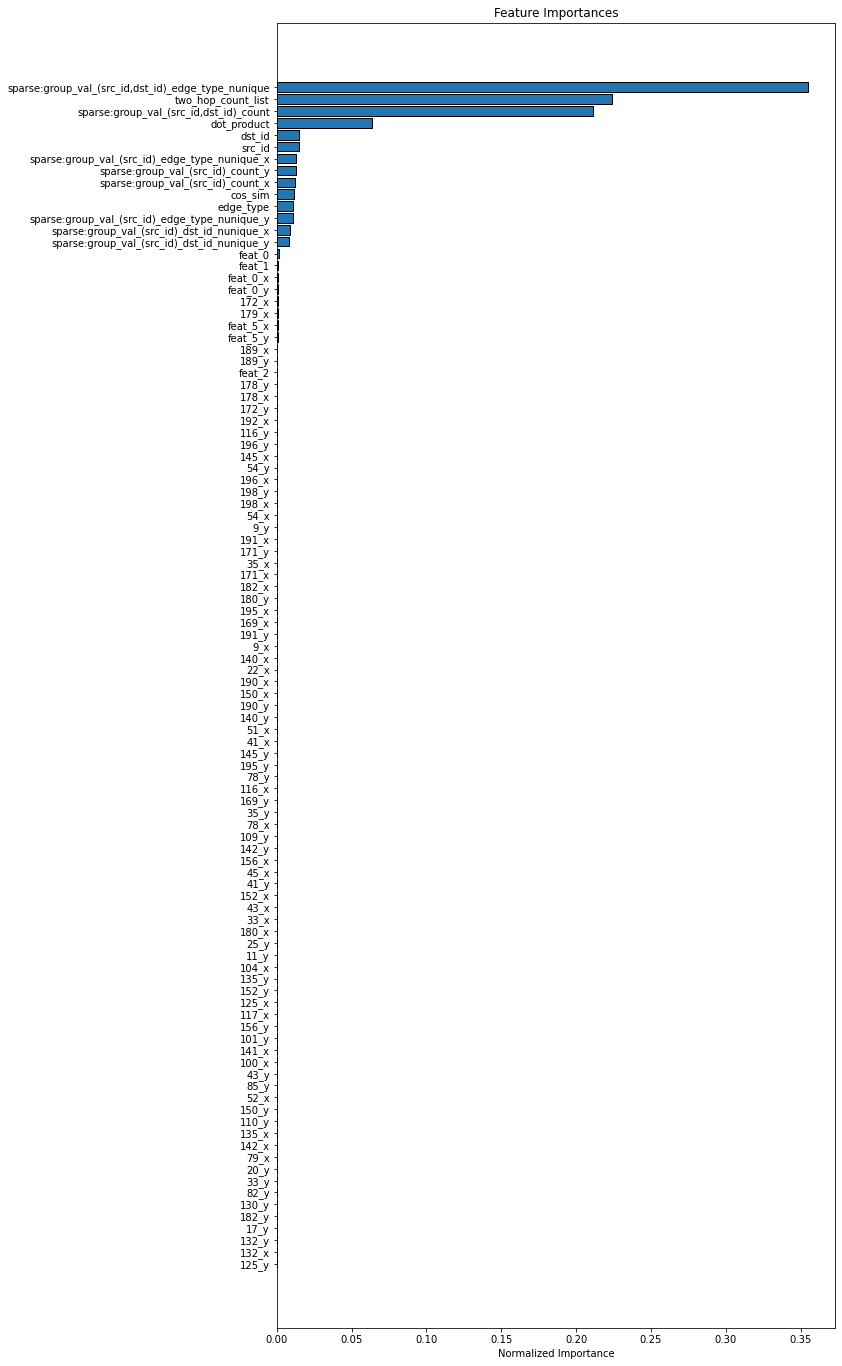

['sparse:group_val_(src_id,dst_id)_edge_type_nunique', 'two_hop_count_list', 'sparse:group_val_(src_id,dst_id)_count', 'dot_product', 'dst_id', 'src_id', 'sparse:group_val_(src_id)_edge_type_nunique_x', 'sparse:group_val_(src_id)_count_y', 'sparse:group_val_(src_id)_count_x', 'cos_sim', 'edge_type', 'sparse:group_val_(src_id)_edge_type_nunique_y', 'sparse:group_val_(src_id)_dst_id_nunique_x', 'sparse:group_val_(src_id)_dst_id_nunique_y', 'feat_0', 'feat_1', 'feat_0_x', 'feat_0_y', '172_x', '179_x', 'feat_5_x', 'feat_5_y', '189_x', '189_y', 'feat_2', '178_y', '178_x', '172_y', '192_x', '116_y', '196_y', '145_x', '54_y', '196_x', '198_y', '198_x', '54_x', '9_y', '191_x', '171_y', '35_x', '171_x', '182_x', '180_y', '195_x', '169_x', '191_y', '9_x', '140_x', '22_x', '190_x', '150_x', '190_y', '140_y', '51_x', '41_x', '145_y', '195_y', '78_y', '116_x', '169_y', '35_y', '78_x', '109_y', '142_y', '156_x', '45_x', '41_y', '152_x', '43_x', '33_x', '180_x', '25_y', '11_y', '104_x', '135_y', '152

In [32]:
def plot_feature_importances(df, top_k=15):
    
    df = df.sort_values('importance', ascending = False).reset_index()

    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 24))
    ax = plt.subplot()

    ax.barh(list(reversed(list(df.index[:top_k]))), 
            df['importance_normalized'].head(top_k), 
            align = 'center', edgecolor = 'k')

    ax.set_yticks(list(reversed(list(df.index[:top_k]))))
    ax.set_yticklabels(df['feature'].head(top_k))

    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

top_k = 100
fi_sorted = plot_feature_importances(fi, top_k=top_k)
important_features = [x for x in fi_sorted['feature'].iloc[:top_k]]
print(important_features)